# First Year Project - Project 3: Natural Language Processing
***
#### Group G: Christina Aftzidis, Germán Buttiero, Hubert Wójcik, Laurids Holme Pedersen, Paula Menshikoff
Submission: 03.07.2022
***

This notebook contains the process of training a classifier with (a) tweets containing hate speech and (b) tweets with stance on a certain topic, and classifying them into categories. 

The initial data was obtained from the [TweetEval](https://github.com/cardiffnlp/tweeteval) GitHub repository. 


### Introduction
***

### Running this notebook
*** 

### Required libraries and further imports
***

In [29]:
#general imports
import numpy as np
import re 
import pandas as pd
import Config #stores all our file paths
import string 
from difflib import Differ #for comparing tokenizers

#sklearn imports
from sklearn.metrics import confusion_matrix, balanced_accuracy_score 

#imports for data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#nltk imports
from nltk.tokenize import TweetTokenizer

#importing our classifiers from our script
#from scripts.classifiers import WithStopVectorClassifier, NoStopVectorClassifier, BagOfWordsClassifier, RandomForest, DecisionTree 

#### Imports that need to be installed in the environment the code is run in

In [30]:
#download the spacy pipeline pretrained on the english language
!python -m spacy download en_core_web_lg

In [31]:
#download the list of stopwords
!python -m nltk.downloader stopwords

### Loading the data

***


In [32]:
with open(Config.hate_train_text_path, 'r', encoding = 'utf-8') as infile:
    train_hate = [line.strip() for line in infile]

with open(Config.abortion_train_text_path, 'r', encoding = 'utf-8') as infile:
    train_abortion = [line.strip() for line in infile]

### Preprocessing

***

In this part, we compare TweetTokenizer given by NLTK with the tokenizer provided by our teacher, Christian Hardmeier.

In [43]:
#a tokeniser provided by Christian Hardmeier
def tokenise(line): 
    tokens = []
    unmatchable = []

    # Compile patterns for speedup
    token_pat = re.compile(r'\w+')
    skippable_pat = re.compile(r'\s+')  # typically spaces

    # As long as there's any material left...
    while line:
        # Try finding a skippable token delimiter first.
        skippable_match = re.search(skippable_pat, line)
        if skippable_match and skippable_match.start() == 0:
            # If there is one at the beginning of the line, just skip it.
            line = line[skippable_match.end():]
        else:
            # Else try finding a real token.
            token_match = re.search(token_pat, line)
            if token_match and token_match.start() == 0:
                # If there is one at the beginning of the line, tokenise it.
                tokens.append(line[:token_match.end()])
                line = line[token_match.end():]
            else:
                # Else there is unmatchable material here.
                # It ends where a skippable or token match starts, or at the end of the line.
                unmatchable_end = len(line)
                if skippable_match:
                    unmatchable_end = skippable_match.start()
                if token_match:
                    unmatchable_end = min(unmatchable_end, token_match.start())
                # Add it to unmatchable and discard from line.
                unmatchable.append(line[:unmatchable_end])
                line = line[unmatchable_end:]
    return tokens


#### Loading data using different tokenizers

In [41]:
tt = TweetTokenizer()
tweet_tokeniser = []
tokeniser = []
NUM = 20 #select the first 100 tweets

for line in train_hate[:NUM]:
    tweet_tokeniser += tt.tokenize(line)
    tokeniser += tokenise(line)

#### Printing the difference in tokenizing methods
Selecting the write tokenizer is vital for us, thus we thoroughly investigate the difference between the two tokenizers.

In [42]:
d = Differ()
difference = list(d.compare(tokeniser,tweet_tokeniser))
dif = set()
for word in difference:
    if word[0] in ('+', '-') and word not in dif:
        dif.add(word)
print(dif)

{"+ that's", '- Spain', '+ …', '- And', '+ anti-immigrant', '+ ~', '+ 😂', '- I', '+ ,', "+ NGO's", '- YesAllMen', '+ ...', '+ #YesAllMen', '- user', '+ ?', '+ 😎', '+ #RefugeesNotWelcome', '- immigrant', '+ tweeted.And', '+ #Spain', '- RefugeesNotWelcome', '- that', '+ !', '+ @user', '+ .', '- tweeted', '- m', '- s', "+ I'm", '+ -', '+ 😡', '- NGO', '- anti', '+ "', '+ :', "+ '"}


As we can see from the printed difference, the TweetTokenizer takes **emoticons**, **hashtags**, **mentions** (@user) into account and is generally more suited for the task of tokenizing tweets.

### Characterising the data

***


In [ ]:
complete_hate = ' '.join(train_hate)
complete_abortion = ' '.join(train_abortion)

complete_hate = complete_hate.split()
complete_abortion = complete_abortion.split()

#### Corpus size

In [ ]:
print(f'The corpus size for the hate train set is {len(complete_hate)}')
print(f'The corpus size for the abortion train set is {len(complete_abortion)}')

The corpus size for the hate train set is 187397
The corpus size for the abortion train set is 10231


#### Vocabulary size

In [ ]:
print(f'The vocabulary size for the hate train set is {len(set(complete_hate))}')
print(f'The vocabulary size for the abortion train set is {len(set(complete_abortion))}')

The vocabulary size for the hate train set is 32745
The vocabulary size for the abortion train set is 3490


#### Type/Token Ratio

In [ ]:
tw = TweetTokenizer(reduce_len = True, strip_handles = True)

tokens_hate = [tw.tokenize(word) for word in complete_hate]
tokens_abortion = [tw.tokenize(word) for word in complete_abortion]

type_hate = set([item for sublist in tokens_hate for item in sublist])
type_abortion = set([item for sublist in tokens_abortion for item in sublist])

print(f'The type to token ratio for the hate train set is {len(type_hate)/len(tokens_hate)}')
print(f'The type to token ratio for the abortion train set is {len(type_abortion)/len(tokens_abortion)}')

The type to token ratio for the hate train set is 0.12494863845205632
The type to token ratio for the abortion train set is 0.2902942038901378


This tells us that the hate train set is much larger overall but has a lower ratio of types to tokens, i.e. less unique words than the abortion train set.

#### Most frequent tokens

In [ ]:
hate = []
for item in tokens_hate:
    hate += item
punct = []
for word in hate:
    if word not in string.punctuation:
        punct.append(word)
tokh, counth = np.unique(punct, return_counts=True) 
count_sorth = np.argsort(-counth)
print(f'The top ten most frequent tokens in the hate train set are {tokh[count_sorth][:10]}')

abortion = []
for item in tokens_abortion:
    abortion += item
puncta = []
for word in abortion:
    if word not in string.punctuation:
        puncta.append(word)
toka, counta = np.unique(puncta, return_counts=True) 
count_sorta = np.argsort(-counta)
print(f'The top ten most frequent tokens in the abortion train set are {toka[count_sorta][:10]}')

The top ten most frequent tokens in the hate train set are ['the' 'to' 'a' 'and' 'you' 'of' 'in' 'is' 'for' 'I']
The top ten most frequent tokens in the abortion train set are ['#SemST' 'to' 'the' 'a' 'is' 'of' 'for' 'you' 'that' 'I']


The '#SemST' is not an actual word. However, it is at the end of every tweet in our dataset. For training our classifier, we removed it. Here we did not.

#### Tokens that appear only once

In [ ]:
count_up_h = np.argsort(counth)
ch = [item for item in counth if item ==1]
print(f'The tokens that only appear once in the hate train set are {tokh[count_up_h][:len(ch)]}. \
In total there are {len(tokh[count_up_h][:len(ch)])} amount of tokens that appear once.')

count_up_a = np.argsort(counta)
ca = [item for item in counta if item == 1]
print(f'The tokens that only appear once in the abortion train set are {toka[count_up_a][:len(ca)]}. \
In total there are {len(toka[count_up_a][:len(ca)])} amount of tokens that appear once.')

The tokens that only appear once in the hate train set are ['##NoMoreAfricans' 'cleavers' 'clenched' ... 'Hirono' 'MeP' 'Hatred']. In total there are 13730 amount of tokens that appear once.
The tokens that only appear once in the abortion train set are ['#15minutes' 'recognised' 'recognize' ... 'Cora' 'tiny' 'timely']. In total there are 1993 amount of tokens that appear once.


The hate dataset is a lot larger than the abortion dataset and that is also visible when comparing the amount of tokens that appear once, and the unique words overall. However, the list of most frequent words is almost the same. Therefore, we can conclude that the most frequent words do not depend on the subject of the tweets.

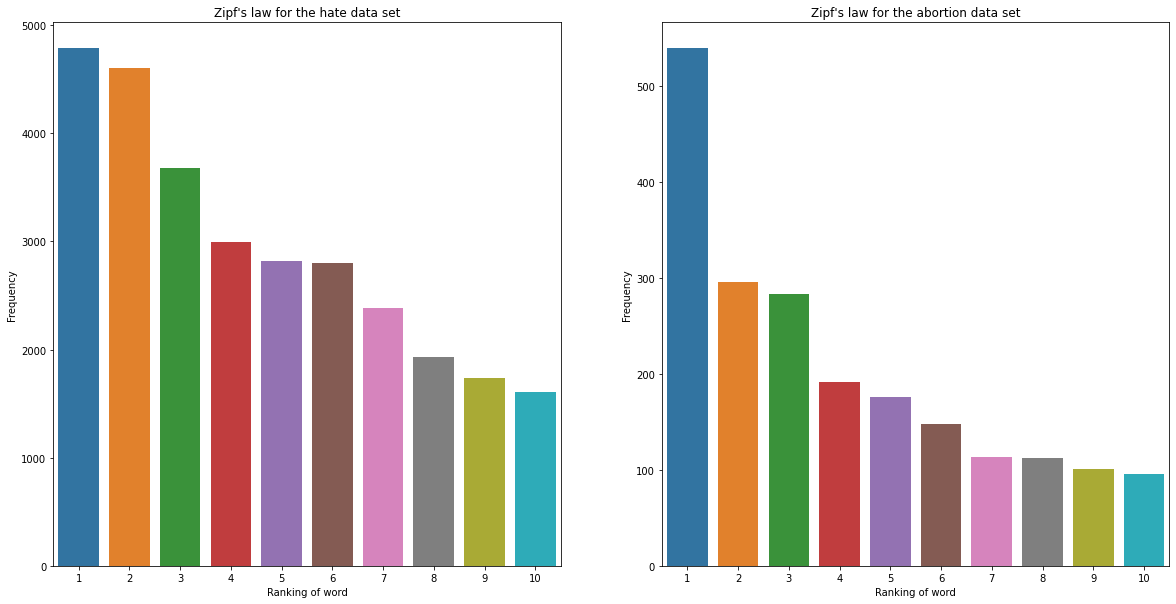

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (20,10))
sns.barplot(x = [i for i in range(1, 11)], y = counth[count_sorth][:10], ax = axs[0]);
sns.barplot(x = [i for i in range(1, 11)], y =counta[count_sorta][:10], ax = axs[1]);

axs[0].set(xlabel = 'Ranking of word', ylabel = 'Frequency', title = 'Zipf\'s law for the hate data set');
axs[1].set(xlabel = 'Ranking of word', ylabel = 'Frequency', title = 'Zipf\'s law for the abortion data set');

From these bar plots, it does not look like Zipf's law is true for our datasets.

### Manual annotation and Inter-Annotator Agreement

*** 

report on the inter annotator agreement, including the agreement with the published labels and discuss what phenomena in the data caused the biggest problems for inter-annotator agreement

### Training a classifier

***

run the one with the highest accuracy on the validation set with the test set

### Data Augmentation

***